In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import time
import matplotlib.pyplot as pl
from matplotlib import rcParams
import numpy as np
import itertools as it
from astropy.io import fits
import healpy as hp
from scipy import linalg

from powspecpy import PowSpecEstimator as PSE
from powspecpy import this_project as P

In [6]:
params = {
    'backend': 'pdf',
    'text.latex.preamble': ['\usepackage{gensymb}'],
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'font.family': 'serif',
    'figure.dpi': 300,
    'image.cmap': 'viridis'
}

rcParams.update(params)

## Set global parameters

In [7]:
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
LMAX = 2*NSIDE
BEAMSIZE = 35./60.
BINFACTOR = 32

## C_l and map input

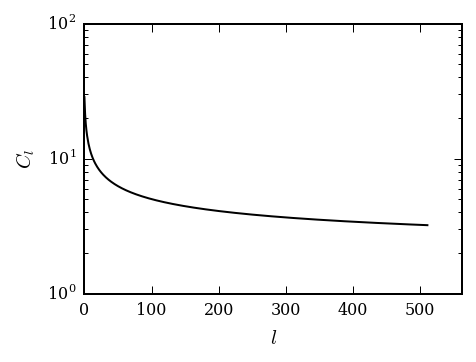

In [8]:
fig = pl.figure(figsize=(3.5, 2.5))
ax = fig.add_axes((0.2, 0.2, 0.75, 0.75))

power = (lambda k: (np.random.random()+5.)*5. / (k + 1.) ** np.random.random()+1.5)
cl_in = power(np.arange(LMAX))
ls = np.arange(cl_in.size)
ax.semilogy(cl_in, c='k')
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$C_l$')

ax.set_xlim([0, LMAX*1.1])

# pl.savefig('../images/cl_in.pdf', dpi=300, transparent=True)

Sigma is 14.863132 arcmin (0.004324 rad) 
-> fwhm is 35.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


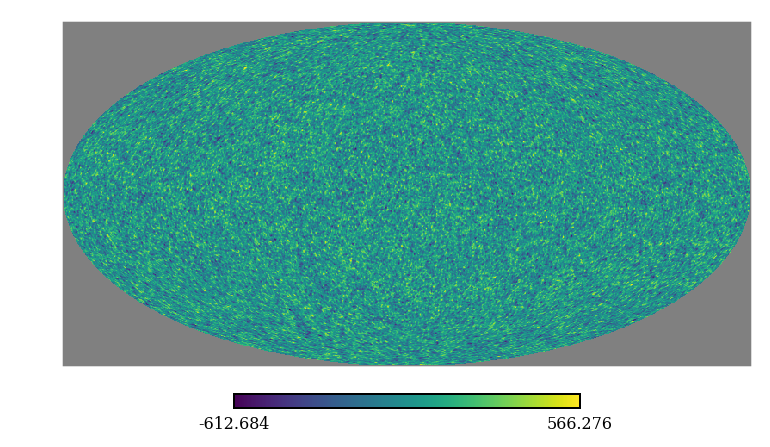

In [9]:
# generate field
random_field = hp.synfast(cl_in, NSIDE, verbose=False, lmax=LMAX)

# simulate beam
random_field = hp.smoothing(random_field, fwhm=np.deg2rad(BEAMSIZE), iter=1)

# view field
fig = pl.figure(1, figsize=(5., 4.))
hp.mollview(random_field, cmap=P.CMAP, title='', unit='', fig=1)

# pl.savefig('../images/map_in.pdf', dpi=300, transparent=True)

## Mask and its power spectrum

In [10]:
full_mask = fits.getdata('/Users/dlenz/projects/planck/mask_galplane_2048.hpx.fits')
mask = hp.ud_grade(full_mask['GAL080'].astype(np.float32), NSIDE, order_in='nest', order_out='ring')
mask = hp.smoothing(mask, fwhm=np.deg2rad(BEAMSIZE), iter=1, verbose=False)

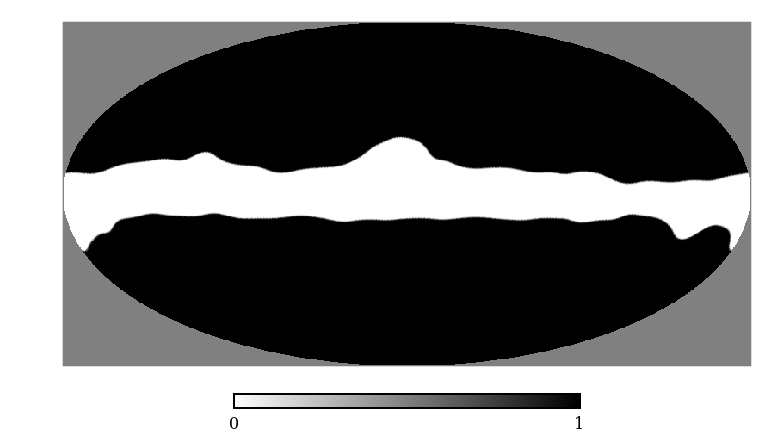

In [11]:
fig = pl.figure(1, figsize=(5., 4.))
hp.mollview(mask, cmap=P.CMAP_GREY, fig=1, title='', min=0., max=1.)
# pl.savefig('../images/sim_mask.pdf', dpi=300, transparent=True)

In [12]:
pse = PSE(random_field, mask=mask, lmax=LMAX, beam=BEAMSIZE)
pse.set_binfactor(BINFACTOR)

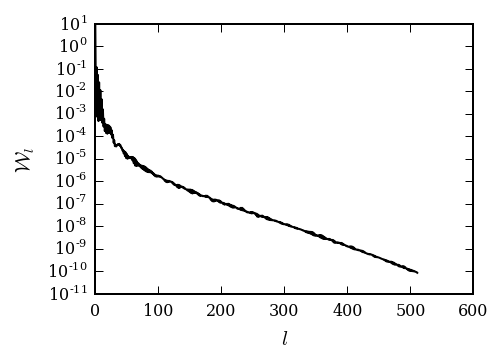

In [13]:
fig = pl.figure(figsize=(3.5, 2.5))
ax = fig.add_axes((0.2, 0.2, 0.75, 0.75))
ax.semilogy(pse.cl_mask, c='k')

ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$\mathcal{W}_l$')

# pl.savefig('../images/cl_mask.pdf', dpi=300, transparent=True)

## Show the window functions

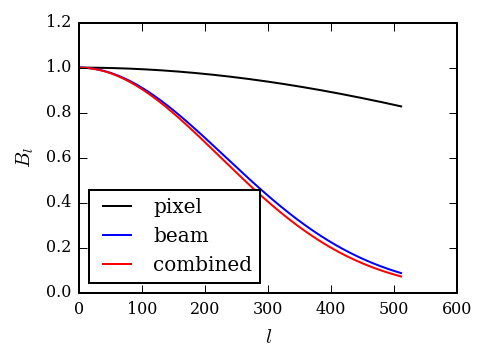

In [14]:
fig = pl.figure(figsize=(3.5, 2.5))
ax = fig.add_axes((0.2, 0.2, 0.75, 0.75))
ax.plot(pse.pixfunc, label='pixel', c='k')
ax.plot(pse.beamfunc, label='beam', c='b')
ax.plot(pse.windowfunc, label='combined', c='r')
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$B_l$')

pl.legend(loc='lower left')

# pl.savefig('../images/windowfunc.pdf', dpi=300, transparent=True)

## Show M_l1l2 and its inverse

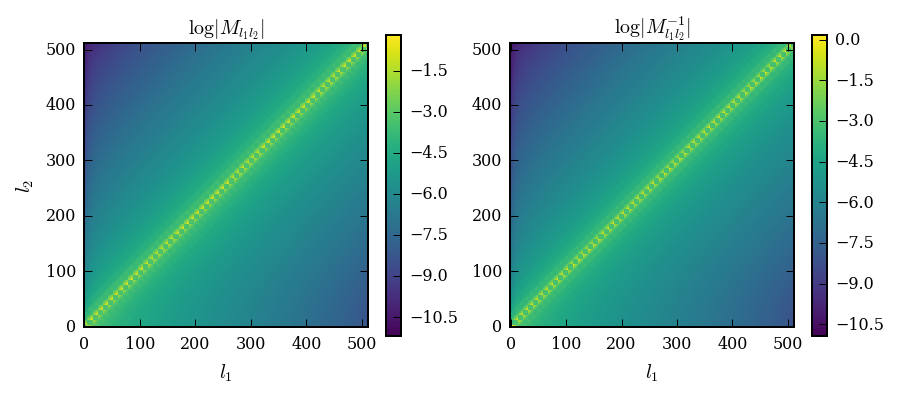

In [15]:
fig, (ax1, ax2) = pl.subplots(figsize=(7., 2.7), ncols=2)

# im1
im1 = ax1.imshow(np.log10(np.abs(pse.M_l1l2)), interpolation='None', cmap=P.CMAP, origin='lower')
ax1.set_title(r'$\log{|M_{l_1l_2}|}$')
ax1.set_xlabel(r'$l_1$')
ax1.set_ylabel(r'$l_2$')
pl.colorbar(im1, ax=ax1)

# im2
im2 = ax2.imshow(np.log10(np.abs(np.linalg.inv(pse.M_l1l2))), interpolation='None', cmap=P.CMAP, origin='lower')
pl.colorbar(im2, ax=ax2)
ax2.set_xlabel(r'$l_1$')
ax2.set_title(r'$\log{|M^{-1}_{l_1l_2}|}$')

# save
# pl.savefig('../images/M_l1l2.pdf', dpi=300, transparent=True)

## Show deconvolved spectra

(0.0, 563.2)

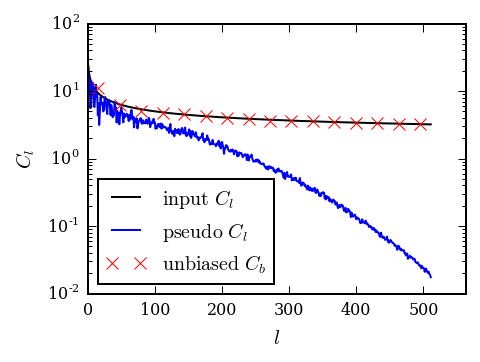

In [16]:
fig = pl.figure(figsize=(3.5, 2.5))
ax = fig.add_axes((0.2, 0.2, 0.75, 0.75))

ax.plot(ls, cl_in, label=r'$\mathrm{input}\ C_l$', c='k')
ax.plot(ls, pse.cl_conv, label=r'$\mathrm{pseudo}\ C_l$', c='b')
# ax.plot(pse.ls, pse.cl_deconv, label='deconv', drawstyle='steps-mid')
ax.plot(pse.bin_centres, pse.cl_deconv_b, label=r'$\mathrm{unbiased}\ C_b $', drawstyle='steps-mid', linestyle='None', marker='x', c='r')
ax.legend(loc='best')
ax.set_yscale('log')
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$C_l$')
ax.set_xlim([0., 1.1*LMAX])
# ax.set_ylim([1.e-1, 1.e1])

# pl.savefig('../images/deconv_comp_in_out.pdf', dpi=300, transparent=True)

## Show uncertainties

In [17]:
C_b = pse.cl_deconv_b

### Analytical

In [18]:
sigma_C_b = np.sqrt(2./(2*pse.bin_centres+1.)/pse.binfactor * pse.cl_deconv_b**2)

### Simulated

In [19]:
N_SIM = 100
C_bs = []
for n in range(N_SIM):
    if not n % 10:
        print '{a} of {b} done...'.format(a=n, b=N_SIM)
    m = hp.synfast(cl_in, NSIDE, verbose=False, lmax=LMAX)
    m = hp.smoothing(m, fwhm=np.deg2rad(BEAMSIZE), iter=1, verbose=False)
    pse_mc = PSE(m, mask=mask, lmax=LMAX, beam=BEAMSIZE)
    pse_mc.set_binfactor(BINFACTOR)
    C_bs.append(pse_mc.cl_deconv_b)
C_bs = np.array(C_bs)

0 of 100 done...
10 of 100 done...
20 of 100 done...
30 of 100 done...
40 of 100 done...
50 of 100 done...
60 of 100 done...
70 of 100 done...
80 of 100 done...
90 of 100 done...


In [20]:
C_bs_av = np.mean(C_bs, axis=0)
C_bd = np.dot((C_b - C_bs_av)[:, None], (C_b - C_bs_av)[:,None].T)
sigma_C_b_mc = np.sqrt(np.diag(C_bd))

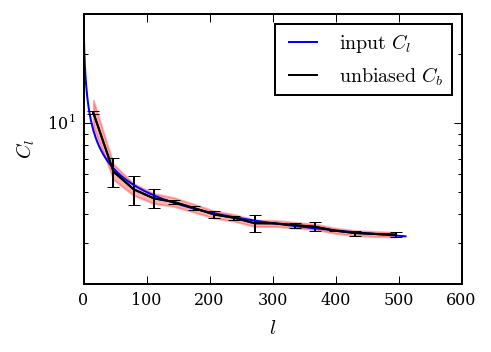

In [21]:
fig = pl.figure(figsize=(3.5, 2.5))
ax = fig.add_axes((0.2, 0.2, 0.75, 0.75))

N_SIGMA = 3.
ax.plot(pse.ls, cl_in, c='b', label=r'$\mathrm{input}\ C_l$')
# reconstruction
ax.errorbar(pse.bin_centres, C_b, yerr=N_SIGMA * sigma_C_b_mc, c='k')
ax.plot(pse.bin_centres, C_b, label=r'$\mathrm{unbiased}\ C_b$', c='k')
# analytical uncertainties
ax.fill_between(pse.bin_centres, C_b-N_SIGMA*sigma_C_b, C_b+N_SIGMA*sigma_C_b, color='r', alpha=0.3)
# simulated uncertainties
# pl.fill_between(pse.bin_centres, C_b-sigma_C_b_mc, C_b+sigma_C_b_mc, color='b', alpha=0.3, label='This work')

ax.set_yscale('log')

# limits
# ax.set_xlim([101., LMAX*1.1])
ax.set_ylim([2.e0, 3.e1])

# labels
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$C_l$')
pl.legend(loc='best')

# ticks
# ax.set_yticks(np.logspace(np.log10(ax.get_ylim()[0]), np.log10(ax.get_ylim()[1]), 5))
# ax.set_yticklabels([2.e0, 1.e1])


# save
# pl.savefig('../images/c_l_sim_full.pdf', dpi=300, transparent=True)

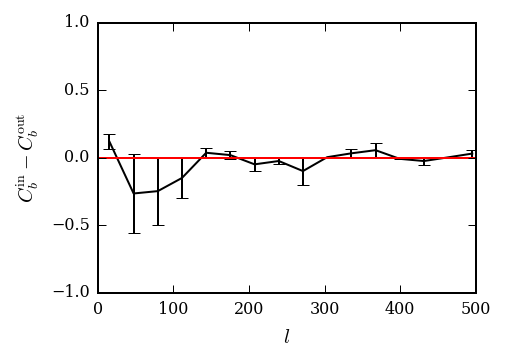

In [23]:
fig = pl.figure(figsize=(3.5, 2.5))
ax = fig.add_axes((0.2, 0.2, 0.75, 0.75))
ax.errorbar(pse.bin_centres, C_b - pse.bin_spectrum(cl_in, BINFACTOR), yerr=sigma_C_b_mc, c='k')
ax.axhline(y=0., c='r')
# ax.set_xlim([100., LMAX*1.1])
ax.set_ylim([-1., 1.])

ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$C_b^{\rm in} - C_b^{\rm out}$')

# pl.savefig('../images/cl_residual.pdf', dpi=300, transparent=False)